In [1]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('pdf', fonttype=42)
sns.set(font_scale=1.25, style='whitegrid')

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 20, 'pdf.fonttype' : 42, 'ps.fonttype' : 42})

df_results = pd.read_feather('../results/black-box_results.feather')

# combine with local results
df_results_local = pd.read_feather('../results/black-box_results_local.feather')
df_results = pd.concat([df_results_local, df_results], axis=0)


symbolic_algs = [
    'AFP', 
    'AFP_FE',
    'BSR',
    'DSR',
    'FFX',
    'FEAT',
    'FEAT S-Split',
    'FEAT D-Split',
    'EPLEX',
    'GP-GOMEA',
    'gplearn',
    'ITEA', 
    'MRGP', 
    'Operon',
    'SBP-GP',
    'AIFeynman'
]
nongp_algs = [
    'BSR',
    'DSR',
    'AIFeynman'
]
gp_algs = [
    'AFP', 
    'AFP_FE',
    'FFX',
    'FEAT S-Split',
    'FEAT D-Split',
    'FEAT',
    'EPLEX',
    'GP-GOMEA',
    'gplearn',
    'ITEA', 
    'MRGP', 
    'Operon',
    'SBP-GP',
]

df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('featStaticSplit','FEAT S-Split'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('featDynamicSplit','FEAT D-Split'))

# removing feat (it was a sanity check)
df_results = df_results[df_results['algorithm']!='feat']

df_results['symbolic_alg'] = df_results['algorithm'].apply(lambda x: x in symbolic_algs)

/home/ch246537/.conda/envs/srbench/lib/python3.9/site-packages/seaborn/axisgrid.py:1609: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  func(x=x, y=y, **kwargs)
/home/ch246537/.conda/envs/srbench/lib/python3.9/site-packages/seaborn/axisgrid.py:1609: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  func(x=x, y=y, **kwargs)
/home/ch246537/.conda/envs/srbench/lib/python3.9/site-packages/seaborn/axisgrid.py:1609: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  func(x=x, y=y, **kwargs)


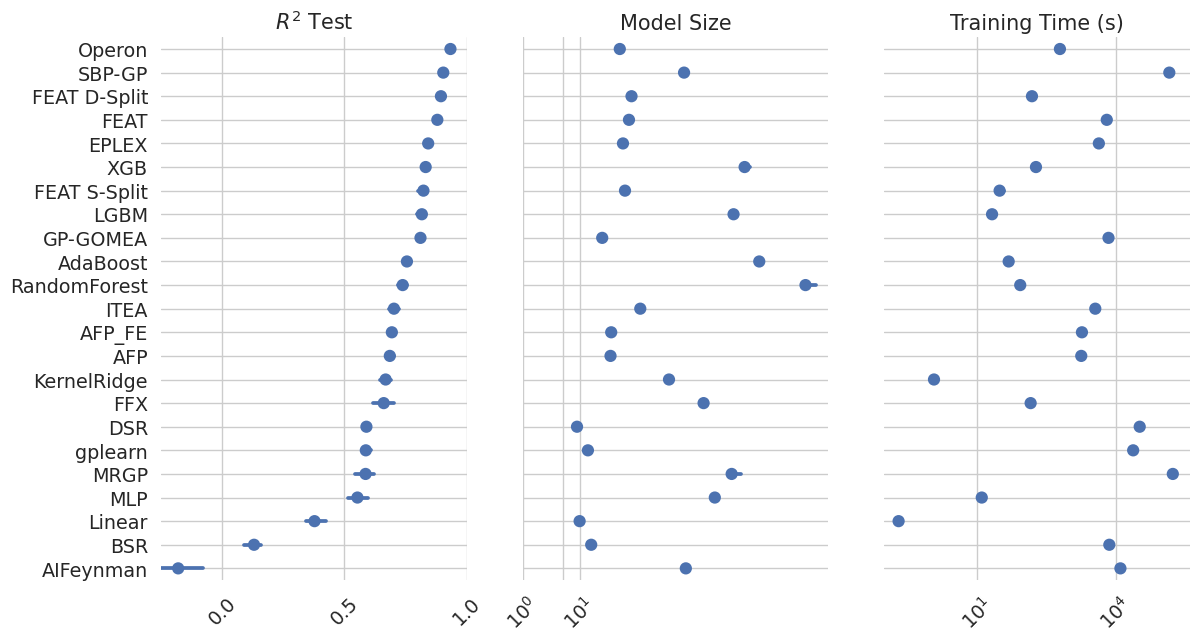

In [2]:
# Make the PairGrid
sns.set_style("whitegrid")

# different options
x_vars=[
        'r2_test',
        'model_size',
        'training time (s)',
]
order = df_results.groupby('algorithm')[x_vars[0]].median().sort_values(ascending=False).index
g = sns.PairGrid(df_results, 
                 x_vars=x_vars,
                 y_vars=['algorithm'],
                 height=6.5, 
                 aspect=0.6,
                )

# Draw a dot plot 

g.map(sns.pointplot, 
      #size=10,
      orient="h",
      #jitter=False,
      order=order,
      palette="rocket",
      #linewidth=1,
      #markeredgecolor='w',
      join=False,
      estimator=np.median,
      n_boot=1000,
      ci=95,
      #annot_kws={'rotation': 45}
     )

# # Use semantically meaningful titles for the columns
titles = [x.replace('_',' ').title().replace('(S)','(s)').replace('R2','$R^2$') for x in x_vars]
g.axes.flat[0].set_ylabel('')

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)
    ax.set_xlabel('')
    
    if any([n in title.lower() for n in ['size','time']]):
        ax.set_xscale('log')
    
    if title == '$R^2$ Test':
        ax.set_xlim([-.25,1])

    if title == "Model Size":
        ax.set_xticks([1, 5, 10])
    # Make the grid horizontal instead of vertical
    ax.yaxis.grid(True)
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.tick_params(axis='x', labelrotation = 45)

sns.despine(left=True, bottom=True)
sns.set(font_scale=2)


#save(name='_'.join(['pairgrid-pointplot']+x_vars))
plt.savefig("figs/main_results.pdf", bbox_inches='tight')

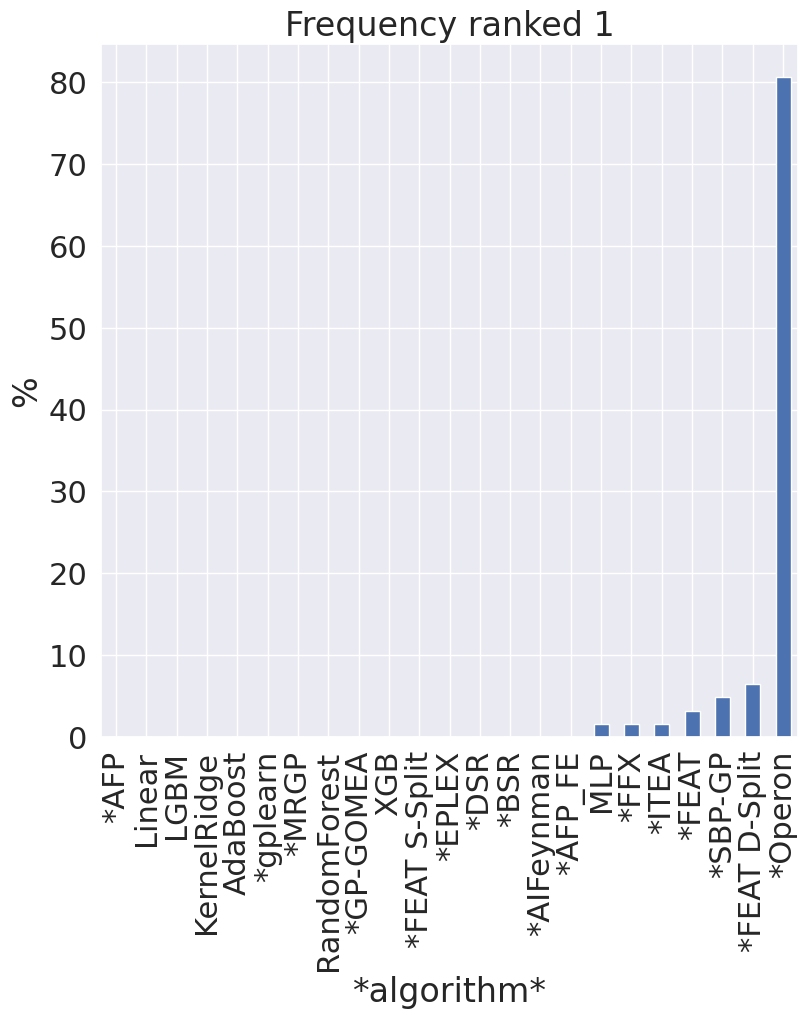

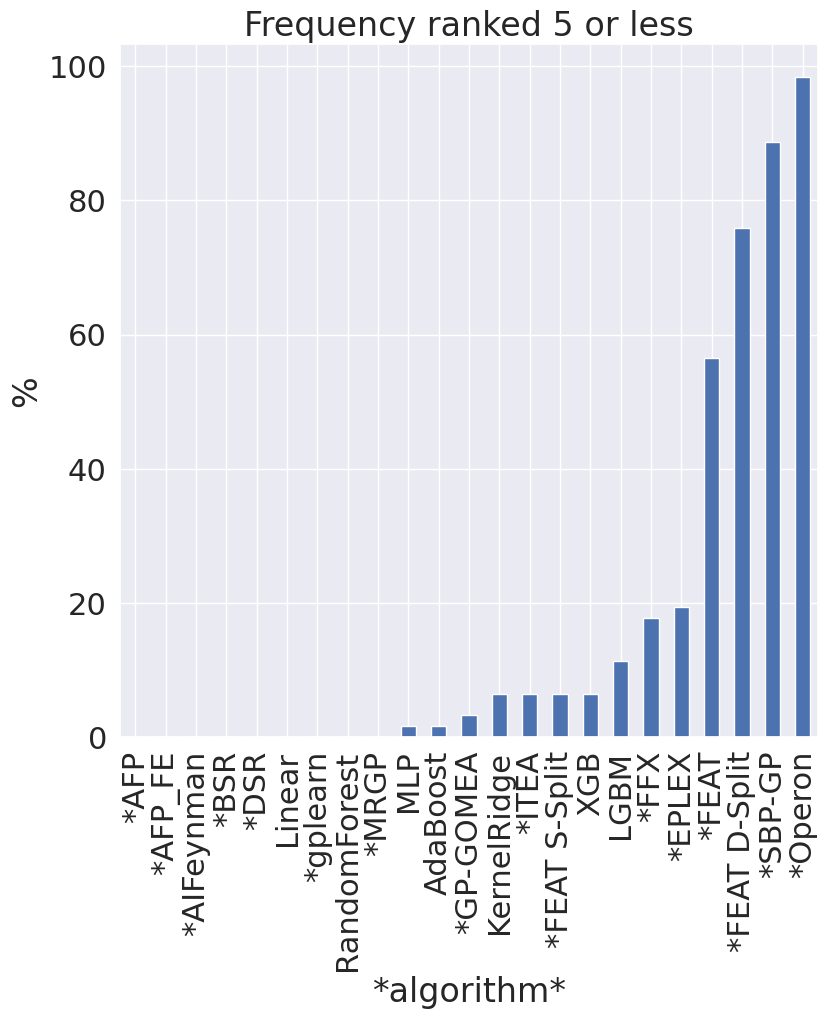

In [3]:
df_results['*algorithm*'] = df_results['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)

df_pivot = pd.pivot_table(df_results[df_results.dataset.str.contains("_fri_")], index='*algorithm*', columns=['dataset'], values='r2_test').apply(lambda x: np.round(x,4))
ranks = df_pivot.rank(ascending=False, method='min')
plt.rcParams.update({'font.size': 30, 'pdf.fonttype' : 42, 'ps.fonttype' : 42})
n = len(ranks.columns)

plt.figure(figsize=(9,9))
ranks.apply(lambda xs: np.array([100.0/n if x < 2 else 0 for x in xs]).sum(), axis=1).sort_values().plot.bar(ylabel='%', title='Frequency ranked 1')
plt.savefig('figs/hist1fri.pdf', bbox_inches="tight")

plt.figure(figsize=(9,9))
ranks.apply(lambda xs: np.array([100.0/n if x < 5 else 0 for x in xs]).sum(), axis=1).sort_values().plot.bar(ylabel='%', title='Frequency ranked 5 or less')
plt.savefig('figs/hist5fri.pdf', bbox_inches="tight")

In [4]:

import Orange
print(Orange.__version__)

# critical difference for Nemenyi with alpha=0.05
def cd_plot(df, pname):
    if df.empty:
        return
    df_pivot = pd.pivot_table(df, index='algorithm', columns=['dataset'], values='r2_test')
    n = len(df_pivot.columns)
    ranks = df_pivot.rank(ascending=False).mean(axis=1).sort_values(ascending=True)    
    names = ranks.index.values[:15]
    avranks = ranks.values[:15]
    
    cd = Orange.evaluation.compute_CD(avranks, n)
    Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=6, textspace=1.5)
    plt.savefig(pname, bbox_inches='tight')

/home/ch246537/.conda/envs/srbench/lib/python3.9/site-packages/pyqtgraph/colors/palette.py:1: RuntimeWarning: PyQtGraph supports Qt version >= 5.15, but 5.12.9 detected.
  from ..Qt import QtGui


3.30.0


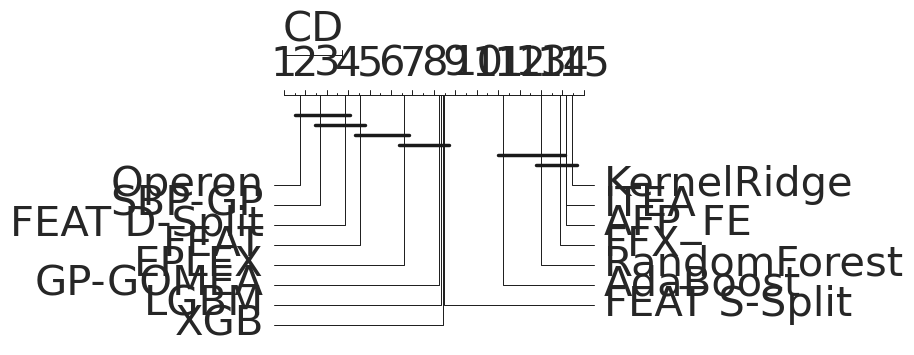

In [5]:
cd_plot(df_results[df_results.dataset.str.contains("_fri_")], "figs/cd_fri_results.pdf")

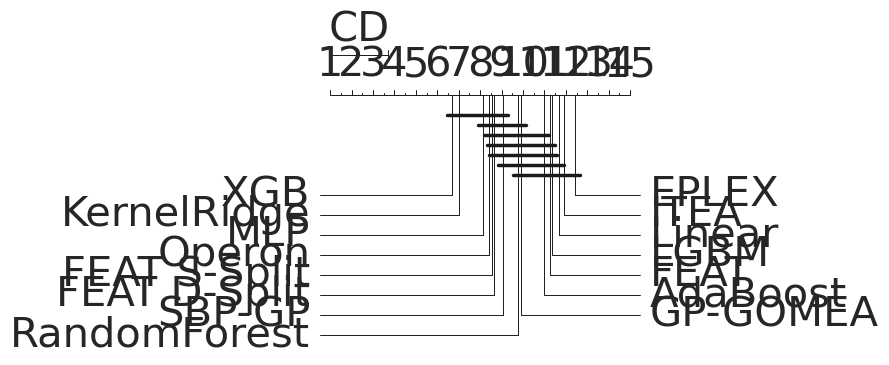

In [6]:
cd_plot(df_results[~df_results.dataset.str.contains("_fri_")],"figs/cd_nonfri_results.pdf")